# Lecture 09

Examples of examining systems of nonlinear equations and looking for limit cycles

In [1]:
import numpy as np

import sympy
from sympy import simplify, Function
from sympy import symbols, pprint
from sympy import sin, cos, asin, acos, pi, Abs
from sympy import Matrix, diff
from sympy import lambdify

from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt
plt.ion()


In [2]:
%matplotlib qt

# Simulating the Van der Pol system

In [3]:
# General inverted pendulum simulator
def vdp(t, state, epsilon):
    x, v = state
    dydt = [v, -x + epsilon*(1 - x**2)*v]
    return dydt

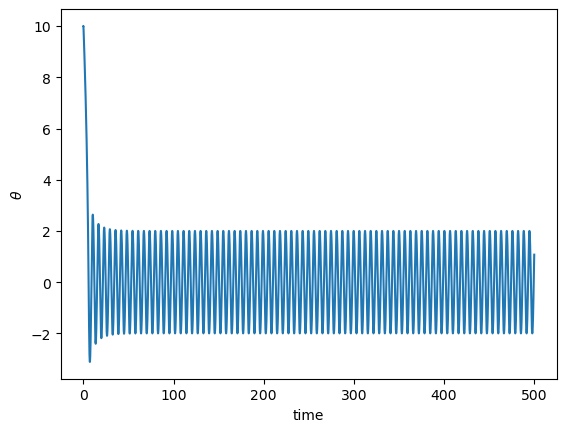

In [4]:
# System constants
epsilon = .1

# Initial condition
x_0 = 10
v_0 = np.random.rand(1)[0] #0.01

dt = 0.001
t_end = 500
time = np.linspace(0,t_end,int(t_end/dt))

sol = solve_ivp(lambda t, y: vdp(t, y, epsilon), 
                [0,t_end], [x_0, v_0], 
                t_eval = time, 
                rtol=1e-8, atol = 1e-8)
plt.figure(1)
# plt.clf()
plt.plot(sol.t, sol.y[0,:])
plt.ylabel('$\\theta$')
plt.xlabel('time')
plt.gcf()

In [5]:
numpoints = 50
rng = 5

[x1_vf, x2_vf] = np.meshgrid(np.linspace(-rng,rng,numpoints), 
                             np.linspace(-rng,rng,numpoints)) 

dynamics = vdp(0, [x1_vf, x2_vf], epsilon)
norm = dynamics[0]**2 + dynamics[1]**2

plt.figure(2)
plt.clf()
plt.quiver(x1_vf, x2_vf, dynamics[0], dynamics[1], norm)

plt.plot(sol.y[0,:], sol.y[1,:])

plt.xlabel(r'$\theta$')
plt.ylabel(r'$\dot{\theta}$')
plt.axis([-rng, rng, -rng, rng])


(-5.0, 5.0, -5.0, 5.0)

In [6]:
numpoints = 30
rng = 4

[x1_vf, x2_vf] = np.meshgrid(np.linspace(-rng,rng,numpoints), 
                             np.linspace(-rng,rng,numpoints)) 

epsilon = 0.2

dynamics = vdp(0, [x1_vf, x2_vf], epsilon)
norm = dynamics[0]**2 + dynamics[1]**2

plt.figure(2)
plt.clf()
plt.quiver(x1_vf, x2_vf, dynamics[0], dynamics[1], norm)

plt.plot(sol.y[0,:], sol.y[1,:])

plt.xlabel(r'$\theta$')
plt.ylabel(r'$\dot{\theta}$')
plt.axis([-rng, rng, -rng, rng])

### Select our point
location = plt.ginput(1)

while len(location) > 0:
    location = location[0]
    plt.plot(location[0], location[1], 'ro')
    plt.pause(0.01);
    
    sol = solve_ivp(lambda t, y: vdp(t, y, epsilon), 
                    [0,t_end], [location[0], location[1]], 
                    t_eval = time, 
                    rtol=1e-8, atol = 1e-8)
    
    plt.plot(sol.y[0,:], sol.y[1,:])
    plt.pause(0.01)
    location = plt.ginput(1)





## Creating the return map for the Van der Pol oscillator

We can use the "events" feature in solve_ivp to keep track of every time an event occurs. 
This could be for instance when the trajectory crosses a specific boundary. 

In [7]:
def Poincare_event(t, state):
    x, y = state
    return y
    
Poincare_event.terminal = False
Poincare_event.direction = -1

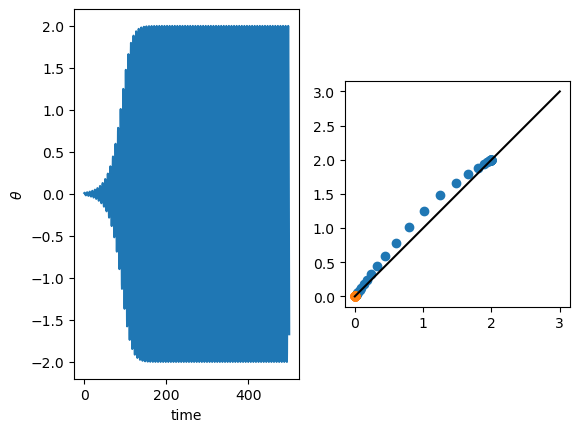

In [8]:
# System constants
epsilon = .1

# Initial condition
x_0 = 0.01
v_0 = 0.01

dt = 0.001
t_end = 500
time = np.linspace(0,t_end,int(t_end/dt))

sol = solve_ivp(lambda t, y: vdp(t, y, epsilon), 
                [0,t_end], [x_0, v_0], 
                t_eval = time, 
                events = Poincare_event,
                rtol=1e-8, atol = 1e-8)


P_events = sol.y_events[0]

plt.figure(1)
plt.clf()
plt.subplot(1,2,1);
plt.plot(sol.t, sol.y[0,:])
plt.ylabel('$\\theta$')
plt.xlabel('time')

plt.subplot(1,2,2);

plt.plot(P_events[:-2], P_events[1:-1],'o')
plt.plot([0,3], [0, 3], 'k-')
plt.gca().set_aspect('equal', 'box')
plt.gcf()


## Run many simulations from different initial conditions

In [9]:
# System constants
epsilon = .1

# Initial condition

dt = 0.001
t_end = 200
time = np.linspace(0,t_end,int(t_end/dt))
plt.figure(1)
plt.clf()

for kk in range(10):
    x_0 = 3*np.random.rand(1)[0]
    v_0 = 3*np.random.rand(1)[0]
    
    sol = solve_ivp(lambda t, y: vdp(t, y, epsilon), 
                    [0,t_end], [x_0, v_0], 
                    t_eval = time, 
                    events = Poincare_event,
                    rtol=1e-8, atol = 1e-8)


    P_events = sol.y_events[0]
    
    
    plt.subplot(1,2,1);
    plt.plot(sol.t, sol.y[0,:])
    plt.ylabel('$\\theta$')
    plt.xlabel('time')

    plt.subplot(1,2,2);
    plt.plot(P_events[:-2], P_events[1:-1],'o')
    plt.plot([0,3], [0, 3], 'k-')
    plt.gca().set_aspect('equal', 'box')
    plt.gcf()





# An exactly solvable return map

Consider the following system.

$\begin{array}{l}
\dot{x}_1=\left(\mu-\left(x_1^2+x_2^2\right)\right) x_1+\omega x_2 \\
\dot{x}_2=\left(\mu-\left(x_1^2+x_2^2\right)\right) x_2-\omega x_1
\end{array}$

Converting to polar coordinates turns this system into 
$\begin{array}{l}
\dot{r}= (\mu - r^2) r \\
\dot{\theta}= -\omega
\end{array}$

Which we can solve for the exact return map as 
$
P(r) = \sqrt{1 + e^{-4 \pi} (r^{-2} - 1)}
$

In [10]:
def Poincare_event2(t, state):
    x1, x2 = state
    return x2
    
Poincare_event2.terminal = False
Poincare_event2.direction = -1

def dynamics_fun(t, state, mu, omega, eps):
    x1, x2 = state
    dydt = [eps*(mu - (x1**2 + x2**2))*x1 + omega*x2, 
            eps*(mu - (x1**2 + x2**2))*x2 - omega*x1, ]
    return dydt

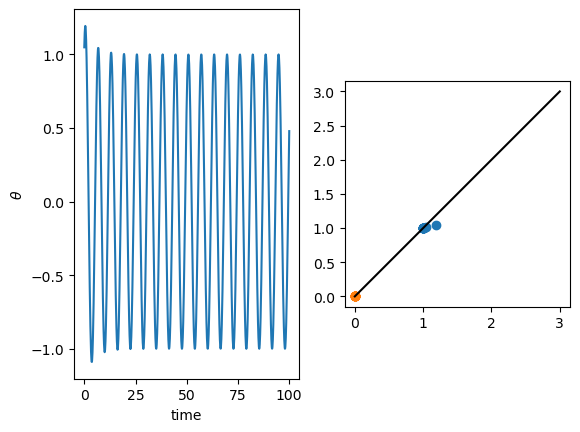

In [11]:
numpoints = 30
rng = 5

[x1_vf, x2_vf] = np.meshgrid(np.linspace(-rng,rng,numpoints), 
                             np.linspace(-rng,rng,numpoints)) 

mu = 1
omega = 1
eps =  .1
t_end = 100

######### Plot the vector field
dynamics = dynamics_fun(0, [x1_vf, x2_vf], mu, omega, eps)
norm = dynamics[0]**2 + dynamics[1]**2

plt.figure(2)
plt.clf()
plt.quiver(x1_vf, x2_vf, dynamics[0], dynamics[1], norm)

######### Solve for dynamics
x_0 = 3*np.random.rand(1)[0]
v_0 = 3*np.random.rand(1)[0]
sol = solve_ivp(lambda t, y: dynamics_fun(t, y, mu, omega, eps), 
                [0,t_end], [x_0, v_0],  
                events = Poincare_event2,
                rtol=1e-8, atol = 1e-8)


plt.plot(sol.y[0,:], sol.y[1,:])

plt.xlabel(r'$\theta$')
plt.ylabel(r'$\dot{\theta}$')
plt.axis([-rng, rng, -rng, rng])

plt.figure(1)
plt.clf()
P_events = sol.y_events[0]


plt.subplot(1,2,1);
plt.plot(sol.t, sol.y[0,:])
plt.ylabel('$\\theta$')
plt.xlabel('time')

plt.subplot(1,2,2);
plt.plot(P_events[:-2], P_events[1:-1],'o')
plt.plot([0,3], [0, 3], 'k-')
plt.gca().set_aspect('equal', 'box')
plt.gcf()


In [13]:
plt.figure(1)
plt.clf()

mu = 2
omega = 10
epsilon = .1
t_end = 300

p_events_all = []

for kk in range(1):
    x_0 = 20*np.random.rand(1)[0]
    v_0 = 20*np.random.rand(1)[0]

    sol = solve_ivp(lambda t, y: dynamics_fun(t, y, mu, omega, epsilon), 
                    [0,t_end], [x_0, v_0], 
                    events = Poincare_event2,
                    rtol=1e-8, atol = 1e-8)

    P_events = sol.y_events[0]
    
    p_events_all.append(P_events)

    plt.subplot(1,2,1);
    plt.plot(sol.t, sol.y[0,:])
    plt.ylabel('$\\theta$')
    plt.xlabel('time')

    plt.subplot(1,2,2);
    plt.plot(P_events[:-2], P_events[1:-1],'ko')
    plt.plot([0,3], [0, 3], 'k-')
    plt.gca().set_aspect('equal', 'box')
    plt.gcf()
    plt.pause(0.01)
    

tt = np.linspace(0,10,100)


plt.plot(tt, np.sqrt(mu / (1 - np.exp(-4*np.pi*mu*epsilon/omega)*(1 - mu/tt**2)**(1))))


C:\Users\Phillip\AppData\Local\Temp\ipykernel_27968\1727871174.py:40: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(tt, np.sqrt(mu / (1 - np.exp(-4*np.pi*mu*epsilon/omega)*(1 - mu/tt**2)**(1))))


In [14]:
tt = np.linspace(0,10,100)


plt.plot(tt, np.sqrt(mu / (1 - np.exp(-4*np.pi*mu*epsilon/omega)*(1 - mu/tt**2)**(1))))


C:\Users\Phillip\AppData\Local\Temp\ipykernel_27968\2235743083.py:4: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(tt, np.sqrt(mu / (1 - np.exp(-4*np.pi*mu*epsilon/omega)*(1 - mu/tt**2)**(1))))


In [15]:
sol

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 174464
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.00000000e+00, 1.49349293e-03, 2.96153934e-03, ...,
       2.99985835e+02, 2.99995394e+02, 3.00000000e+02])
 t_events: [array([1.17262164e-01, 7.45580696e-01, 1.37389923e+00, 2.00221776e+00,
       2.63053629e+00, 3.25885482e+00, 3.88717335e+00, 4.51549188e+00,
       5.14381041e+00, 5.77212894e+00, 6.40044747e+00, 7.02876600e+00,
       7.65708453e+00, 8.28540306e+00, 8.91372159e+00, 9.54204012e+00,
       1.01703587e+01, 1.07986772e+01, 1.14269957e+01, 1.20553142e+01,
       1.26836328e+01, 1.33119513e+01, 1.39402698e+01, 1.45685884e+01,
       1.51969069e+01, 1.58252254e+01, 1.64535440e+01, 1.70818625e+01,
       1.77101810e+01, 1.83384995e+01, 1.89668181e+01, 1.95951366e+01,
       2.02234551e+01, 2.08517737e+01, 2.14800922e+01, 2.21084107e+01,
       2.27367293e+01, 2.33650478e+01, 2.39933663e+

In [29]:
yy=p_events_all[0]

In [30]:
yy[:,0]

array([7.78247198, 2.84029446, 2.19514555, 1.91556999, 1.75933102,
       1.66115169, 1.59520925, 1.54902124, 1.51574656, 1.49129897,
       1.47308132, 1.45936479, 1.44895745, 1.44101513, 1.43492734,
       1.43024543, 1.4266355 , 1.42384664, 1.42168883, 1.42001731,
       1.41872133, 1.41771581, 1.41693523, 1.416329  , 1.41585804,
       1.41549206, 1.41520761, 1.4149865 , 1.41481459, 1.41468093,
       1.414577  , 1.41449618, 1.41443334, 1.41438446, 1.41434645,
       1.41431689, 1.4142939 , 1.41427602, 1.41426212, 1.4142513 ,
       1.41424289, 1.41423635, 1.41423126, 1.4142273 , 1.41422422,
       1.41422183, 1.41421997, 1.41421852, 1.41421739, 1.41421652,
       1.41421583, 1.4142153 , 1.41421489, 1.41421457, 1.41421432,
       1.41421413, 1.41421398, 1.41421386, 1.41421377, 1.4142137 ,
       1.41421364, 1.4142136 , 1.41421357, 1.41421354, 1.41421352,
       1.4142135 , 1.41421349, 1.41421348, 1.41421348, 1.41421347,
       1.41421347, 1.41421346, 1.41421346, 1.41421346, 1.41421

In [31]:
plt.plot(yy[:,0], 'o-')

In [32]:
plt.clf()
plt.semilogy(np.abs(yy[:,0] - yy[-1,0]), 'o-')